In [ ]:
#### FINAL VERSION ####


from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

from utils import setup_data
from setup_model import get_models 
from datasetlite import DataLoaderLite 


import math 
import torch 



#----- Model Setup -------

TrainingConfig, encoder_model, decoder_model , pad_token_id, tokenizer, extras_dict = get_models() 

l_global_step = 0
l_epoch = 0 
l_loss = 0 

if extras_dict:
    l_global_step = extras_dict["global_step"] 
    l_epoch       = extras_dict["epoch"] 
    l_loss        = extras_dict["loss"]

# torch.mps.empty_cache()
# import gc; gc.collect()


def collate_fn(batch):
    """
    Collate function for DataLoaderLite with captions + detection info.
    Each batch element is a dict:
      {
        "image": Tensor[C,H,W],
        "input_ids": Tensor[L],
        "attention_mask": Tensor[L],
        "bboxes": Tensor[num_img_tokens, 4],
        "class_labels": Tensor[num_img_tokens],
        "objectness": Tensor[num_img_tokens,1]
      }
    """
    images = torch.stack([item["image"] for item in batch])
    
    input_ids = pad_sequence([item["input_ids"] for item in batch],
                             batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence([item["attention_mask"] for item in batch],
                                 batch_first=True, padding_value=0)

    bboxes = torch.stack([item["bboxes"] for item in batch])        # [B, num_img_tokens, 4]
    class_labels = torch.stack([item["class_labels"] for item in batch])  # [B, num_img_tokens]
    objectness = torch.stack([item["objectness"] for item in batch])       # [B, num_img_tokens, 1]

    return {
        "images": images,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "bboxes": bboxes,
        "class_labels": class_labels,
        "objectness": objectness
    }


train_dataset, val_dataset,  id_to_name, name_to_id  = setup_data(TrainingConfig.number_of_items)
train_dataset_cocooptions = DataLoaderLite(train_dataset, caption_length=TrainingConfig.caption_len, tokenizer=tokenizer)
val_dataset_cocooptions = DataLoaderLite(val_dataset, caption_length=TrainingConfig.caption_len, tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset_cocooptions, batch_size=TrainingConfig.batch_size, collate_fn=collate_fn, shuffle=True)
val_dataloader = DataLoader(val_dataset_cocooptions, batch_size=TrainingConfig.batch_size, collate_fn=collate_fn, shuffle=False)


total_steps = len(train_dataloader)  * TrainingConfig.epochs
formatted_str = f"Training details vocab size {TrainingConfig.vocab_size} batch size {TrainingConfig.batch_size} image size {TrainingConfig.image_h}x{TrainingConfig.image_w}"
formatted_str+= f" total steps {total_steps} epochs {TrainingConfig.epochs}"
formatted_str+= f"Max loss {math.log(TrainingConfig.vocab_size)}"
formatted_str+= f"Perplexity {math.exp(math.log(TrainingConfig.vocab_size))}"
formatted_str+= f"\nTotal Training Records = {len(train_dataloader)}"

print (formatted_str)


In [ ]:
#### TRAINING LOOP #####


from torch.cuda.amp import GradScaler

import numpy as np 
from utils import calculate_total_train_params, save_to_checkpoint
import torch.nn as nn 



scaler = GradScaler()

loss_list = []


def eval():
    decoder_model.eval()
    encoder_model.eval()
    val_loss = 0
    count = 0
    with torch.no_grad():
        for val_batch in val_dataloader:
            # Unpack batch dict
            image_tensor = val_batch["images"].to(device)
            caption_tensor = val_batch["input_ids"].to(device)
            attention_mask = val_batch["attention_mask"].to(device)
            bboxes = val_batch["bboxes"].to(device)
            class_labels = val_batch["class_labels"].to(device)
            objectness = val_batch["objectness"].to(device)

            with torch.autocast("mps", enabled=True, dtype=torch.bfloat16):
                x_embed = encoder_model(image_tensor)
                # decoder_model should return caption_loss and detection_loss
                #img_features, captions_tensor, attention_mask=None, bbox_targets=None, class_targets=None, objectness_targets=None, 
                logits, bbox_preds, objectness_pred, class_pred, loss_list = decoder_model(
                    x_embed, 
                    caption_tensor, 
                    attention_mask,
                    bbox_targets=bboxes,
                    class_targets=class_labels,
                    objectness_targets=objectness,
                    mode="train"
                )
                total_loss, lm_loss, loss_bbox, loss_giou, loss_ce, objectness_loss = loss_list[:]

                # combine losses
                total_val_loss = total_loss

            val_loss += total_val_loss.item()
            count += 1
            if count > 2: break  # quick validation
    val_loss /= count
    decoder_model.train()
    encoder_model.train()
    print(f"Epoch {epoch+1}: train_loss={total_loss/len(train_dataloader):.4f}, val_loss={val_loss:.4f}")
    return val_loss




def should_stop(loss_list):
    last_ten_loss = loss_list[-50*4:]
    threshold = 0.5
    if len(last_ten_loss)==50*4 and len(loss_list)>=50*4:
        diffs = np.diff(last_ten_loss)
        step_trends = []
        for d in diffs:
            if d > threshold:
                step_trends.append("increasing")
            elif d < -threshold:
                step_trends.append("decreasing")
            else:
                step_trends.append("steady")

        if all(t == "steady" for t in step_trends):
            return True 
        else:
            print ("Trend", step_trends)
    return False 



##### Setup Training #####
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_token_id)
all_params = calculate_total_train_params(encoder_model, decoder_model)


print (f"Trainable parameters in encoder model: {sum(p.numel() for p in all_params if p.requires_grad)/1e6} M")

optimizer = torch.optim.AdamW(all_params, lr=TrainingConfig.lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps/TrainingConfig.accumulation_steps, eta_min=1e-6)

import time 
start_time = time.time()
total_loss = 0 
best_val_loss = float("inf")
epochs_no_improve = 0
steps_no_improve = 0
patience_steps = 10
stop = False 
device = torch.device("mps")


N_EPOCHS = TrainingConfig.epochs - l_epoch

print (f"PREVIOUS LOSS {l_loss} AT GLOBAL STEP {l_global_step} AT EPOCH {l_epoch}")


for epoch in range(N_EPOCHS):

    for step, batch in enumerate(train_dataloader):
        # Unpack batch
        image_tensor = batch["images"].to(device)
        caption_tensor = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        bboxes = batch["bboxes"].to(device)
        class_labels = batch["class_labels"].to(device)
        objectness = batch["objectness"].to(device)
        B, C, H, W = image_tensor.shape

        global_step = epoch * len(train_dataloader) + step + 1 

        with torch.autocast("mps", enabled=True, dtype=torch.bfloat16):
            x_embed = encoder_model(image_tensor) # (B, N, embed_size) 
            logits, bbox_preds, objectness_pred, class_pred, loss_list   = decoder_model(
                x_embed, 
                caption_tensor, 
                attention_mask,
                bbox_targets=bboxes,
                class_targets=class_labels,
                objectness_targets=objectness
            ) # (B, T-1, vocab_size)

            loss_1, lm_loss, loss_bbox, loss_giou, loss_ce, objectness_loss = loss_list[:]

            if global_step % 300 == 0:

                print (f"LM LOSS: {lm_loss.item():.4f} | "
                       f"BBOX LOSS: {loss_bbox.item():.4f} |"
                        f"GIOU LOSS: {loss_giou.item():.4f} |"
                         f"CE LOSS: {loss_ce.item():.4f} |"
                          f"OBJECTIVENESS LOSS: {objectness_loss.item():.4f} |"
                       )

                  
            loss =  loss_1 / TrainingConfig.accumulation_steps

        # x_embed = image_encoder(image_tensor) # (B, N, embed_size) 
        # logits, caption_loss  = caption_encoder(x_embed, caption_tensor, attention_mask)  # (B, T-1, vocab_size)
        # loss = caption_loss / TrainingConfig.accumulation_steps  


        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(all_params, max_norm=5.0)
        if (step + 1) % TrainingConfig.accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        total_loss += loss.item() * TrainingConfig.accumulation_steps  


        if global_step %100==0:
            val_loss = eval()
            loss_list.append(val_loss)
            save_to_checkpoint(encoder_model, decoder_model, optimizer, epoch, loss, global_step)

            if should_stop(loss_list):
                stop = True 
                break

          # estimate remaining time every 100 steps
        if global_step % 100 == 0:
            elapsed = time.time() - start_time
            steps_per_sec = global_step / elapsed
            remaining_steps = total_steps - global_step
            est_remaining = remaining_steps / steps_per_sec
            est_total = total_steps / steps_per_sec

            print(f"epoch {epoch+1}/{TrainingConfig.epochs} step {step}/{len(train_dataloader)} "
                  f"Loss: {loss.item()*TrainingConfig.accumulation_steps:.4f} | "
                  f"Elapsed: {elapsed/60:.2f} min | "
                  f"ETA: {est_remaining/60:.2f} min | "
                  f"Total est: {est_total/60:.2f} min | "
                  f"Memory: {torch.mps.current_allocated_memory() / 1e9:.2f} GB , \ {torch.mps.driver_allocated_memory() / 1e9:.2f} GB | "
                  f"Perplexity {math.exp(loss.item()*TrainingConfig.accumulation_steps):.2f}"
                  )
            
            # save_model(image_encoder=image_encoder, caption_encoder=caption_encoder)

    if (step + 1) % TrainingConfig.accumulation_steps != 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(all_params, 5.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    if stop:
        save_to_checkpoint(encoder_model, decoder_model, optimizer, epoch, loss, global_step)
        break
    
    del image_tensor, caption_tensor, x_embed, logits
    torch.mps.empty_cache()
    import gc; gc.collect()

In [ ]:
! export PYTORCH_ENABLE_MPS_FALLBACK=1 

In [1]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

from utils import setup_data
from setup_model import get_models 
from datasetlite import DataLoaderLite 


import math 
import torch 


#----- Model Setup -------

tup = get_models() 

TrainingConfig, tokenizer = tup[0], tup[-1]

torch.mps.empty_cache()
import gc; gc.collect()


#### FINAL VERSION ####


from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

from utils import setup_data
from setup_model import get_models 
from datasetlite import DataLoaderLite 


import math 
import torch 



#----- Model Setup -------

TrainingConfig, encoder_model, decoder_model , pad_token_id, tokenizer, extras_dict = get_models() 

l_global_step = 0
l_epoch = 0 
l_loss = 0 

if extras_dict:
    l_global_step = extras_dict["global_step"] 
    l_epoch       = extras_dict["epoch"] 
    l_loss        = extras_dict["loss"]

# torch.mps.empty_cache()
# import gc; gc.collect()


def collate_fn(batch):
    """
    Collate function for DataLoaderLite with captions + detection info.
    Each batch element is a dict:
      {
        "image": Tensor[C,H,W],
        "input_ids": Tensor[L],
        "attention_mask": Tensor[L],
        "bboxes": Tensor[num_img_tokens, 4],
        "class_labels": Tensor[num_img_tokens],
        "objectness": Tensor[num_img_tokens,1]
      }
    """
    images = torch.stack([item["image"] for item in batch])
    
    input_ids = pad_sequence([item["input_ids"] for item in batch],
                             batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence([item["attention_mask"] for item in batch],
                                 batch_first=True, padding_value=0)

    bboxes = torch.stack([item["bboxes"] for item in batch])        # [B, num_img_tokens, 4]
    class_labels = torch.stack([item["class_labels"] for item in batch])  # [B, num_img_tokens]
    objectness = torch.stack([item["objectness"] for item in batch])       # [B, num_img_tokens, 1]

    return {
        "images": images,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "bboxes": bboxes,
        "class_labels": class_labels,
        "objectness": objectness
    }

TrainingConfig.batch_size = 1 


train_dataset, val_dataset, id_to_name, name_to_id  = setup_data(TrainingConfig.number_of_items)
train_dataset_cocooptions = DataLoaderLite(train_dataset, caption_length=TrainingConfig.caption_len, tokenizer=tokenizer)
train_dataset_cocooptions = DataLoaderLite(val_dataset, caption_length=TrainingConfig.caption_len, tokenizer=tokenizer)

train_dataloader = DataLoader(train_dataset_cocooptions, batch_size=TrainingConfig.batch_size, collate_fn=collate_fn, shuffle=True)
val_dataloader = DataLoader(train_dataset_cocooptions, batch_size=TrainingConfig.batch_size, collate_fn=collate_fn, shuffle=False)


total_steps = len(train_dataloader)  * TrainingConfig.epochs
formatted_str = f"Training details vocab size {TrainingConfig.vocab_size} batch size {TrainingConfig.batch_size} image size {TrainingConfig.image_h}x{TrainingConfig.image_w}"
formatted_str+= f" total steps {total_steps} epochs {TrainingConfig.epochs}"
formatted_str+= f"Max loss {math.log(TrainingConfig.vocab_size)}"
formatted_str+= f"Perplexity {math.exp(math.log(TrainingConfig.vocab_size))}"
formatted_str+= f"\nTotal Training Records = {len(train_dataloader)}"

print (formatted_str)



/Users/preetamverma/Desktop/multimodel/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



	 Loading Model Classes and Tokenizer ..!


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`



	 Resizing Tokenizer ..!

	 Freezing CLIP & GPT Model ..!
Trainable parameters in  model:
277403478
Loading from Checkpoint...!
epoch 0
loss 2.9209883213043213
global_step 3800

	 Loading Model Classes and Tokenizer ..!

	 Resizing Tokenizer ..!

	 Freezing CLIP & GPT Model ..!
Trainable parameters in  model:
277403478
Loading from Checkpoint...!
epoch 0
loss 2.9209883213043213
global_step 3800
loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
loading annotations into memory...
Done (t=3.29s)
creating index...
index created!
Training details vocab size 50259 batch size 1 image size 224x224 total steps 160000 epochs 10Max loss 10.824944914361643Perplexity 50259.00000000004
Total Training Records = 16000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.752097..2.089017].


=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
	 bbox_preds torch.Size([1, 64, 4])
	 objectness_pred torch.Size([1, 64])
	 class_pred torch.Size([1, 64])
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Detected objects:
 - carrot (ID: 57), Score: 1.00, BBox: [154.4375, 161.4375, 291.8125, 284.8125]
 - carrot (ID: 57), Score: 1.00, BBox: [180.03125, 181.78125, 266.21875, 264.46875]
 - carrot (ID: 57), Score: 0.99, BBox: [194.6875, 197.96875, 249.8125, 246.53125]
 - carrot (ID: 57), Score: 0.99, BBox: [161.875, 155.75, 282.625, 288.75]
 - carrot (ID: 57), Score: 0.99, BBox: [187.03125, 183.96875, 257.46875, 260.53125]
 - carrot (ID: 57), Score: 0.99, BBox: [-106.83203125, -103.6328125, 114.54296875, 117.7421875]
 - carrot (ID

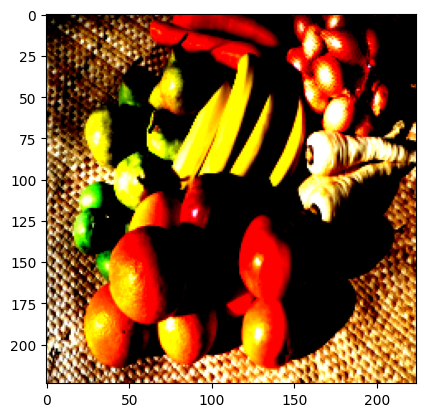

In [6]:
from torch.nn import functional as F

import matplotlib.pyplot as plt 
from transformers.generation.logits_process import LogitsProcessorList
from transformers import LogitsProcessorList, MinLengthLogitsProcessor, RepetitionPenaltyLogitsProcessor

from transformers.generation.logits_process import (
    TemperatureLogitsWarper,
    TopKLogitsWarper,
    TopPLogitsWarper,
)

# Chain multiple warpers
warpers = LogitsProcessorList([
    TemperatureLogitsWarper(0.3),
    TopKLogitsWarper(20),
    TopPLogitsWarper(0.95),
])

processors = LogitsProcessorList([
    RepetitionPenaltyLogitsProcessor(penalty=1.2)
])

from utils import load_from_checkpoint 

encoder, decoder , epoch, loss , global_step, tokenizer = load_from_checkpoint()




device = torch.device("mps")


def generate_caption(image_tensor, max_len=30, use_image=True):
    encoder.eval()
    decoder.eval()

    image_tensor = image_tensor.to(device).unsqueeze(0)

    # Only process image if use_image is True
    if use_image:
        x_embed = encoder(image_tensor)
    else:
        # Create dummy embeddings if not using image
        x_embed = torch.zeros((1, 50, decoder.embed_size), device=device)
    
    # Start with the START token
    start_id = tokenizer.convert_tokens_to_ids("<START>")
    generated_ids = torch.tensor([[start_id]], device=device)
    end_token_id = tokenizer.convert_tokens_to_ids("<END>")

    # Setup warpers and processors for better text generation
    warpers_list = LogitsProcessorList([
        TemperatureLogitsWarper(0.7),  # Lower temperature for less randomness
        TopKLogitsWarper(50),         # More top-k options
        TopPLogitsWarper(0.92),       # Slightly more conservative top-p
    ])
    
    processors_list = LogitsProcessorList([
        RepetitionPenaltyLogitsProcessor(penalty=1.5),  # Stronger repetition penalty
        # MinLengthLogitsProcessor(5, end_token_id)      # Ensure minimum caption length
    ])

    for _ in range(max_len):
        with torch.no_grad():
            # The decoder internally handles creating the appropriate attention mask
            # Just pass a simple mask for the text tokens - decoder will handle the rest
            attn_mask = torch.ones(1, generated_ids.shape[1], dtype=torch.long, device=device)
            
            # Important: Use mode="inference" for generation
            logits, bbox_preds, objectness_pred, class_pred, loss_list = decoder(x_embed, generated_ids, attn_mask, mode="inference")

            # Get the logits for the next token only (the last position)
            # The -1 index accounts for the concatenated image tokens in the decoder
            next_token_idx = -1
            next_logits = logits[:, next_token_idx, :]
            
            # Process logits to avoid repetition
            next_logits = processors_list(generated_ids, next_logits)
            
            # Apply temperature and top-k/top-p filtering
            next_logits = warpers_list(generated_ids, next_logits)
            
            # Convert to probabilities
            probs = F.softmax(next_logits, dim=-1)
            
            # Sample the next token
            next_token_id = torch.multinomial(probs, num_samples=1)
            
            # Add the new token to our sequence
            generated_ids = torch.cat([generated_ids, next_token_id], dim=1)
            
            # Stop if we generated an END token
            if next_token_id.item() == end_token_id:
                break

    # Decode the generated tokens to text, skipping special tokens
    caption = tokenizer.decode(generated_ids.squeeze().tolist(), skip_special_tokens=True)
    # Optional: visualize predicted boxes
    image_tensor = image_tensor.to(torch.float32)

    print ("=*="*60)
    print (f"\t bbox_preds {bbox_preds.shape}")
    print (f"\t objectness_pred {objectness_pred.shape}")
    print (f"\t class_pred {class_pred.shape}")
    print ("=*="*60)


    if 1:
        bboxes = bbox_preds[0].to(torch.float32).cpu().numpy()   # normalized [cx,cy,w,h]. @[1,64,4]
        class_pred = class_pred[0].to(torch.float32).cpu().numpy() #[1, 64]
        scores = objectness_pred[0].to(torch.float32).cpu().numpy() #[1, 64]

        detections = []
        for (cx, cy, w, h), score, cls_id in zip(bboxes, scores, class_pred):
            if score > 0.2:  # confidence threshold
                x1 = (cx - w/2) * image_tensor.shape[-1]
                y1 = (cy - h/2) * image_tensor.shape[-2]
                x2 = (cx + w/2) * image_tensor.shape[-1]
                y2 = (cy + h/2) * image_tensor.shape[-2]

                detections.append({
                    "class_id": int(cls_id),
                    "class_name": id_to_name[int(cls_id)] if int(cls_id) < len(id_to_name) else f"cls_{int(cls_id)}",
                    "score": float(score),
                    "bbox": [float(x1), float(y1), float(x2), float(y2)]
                })

        # Sort detections by confidence
        detections = sorted(detections, key=lambda x: x["score"], reverse=True)
    
        # Print detections
        print("Detected objects:")
        for det in detections:
            print(f" - {det['class_name']} (ID: {det['class_id']}), Score: {det['score']:.2f}, BBox: {det['bbox']}")
            

    
    return caption


counter = 0 
# Example usage
for step, batch in enumerate(train_dataloader):
    image_tensor = batch["images"].to(device)
    caption_tensor = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    bboxes = batch["bboxes"].to(device)
    class_labels = batch["class_labels"].to(device)
    objectness = batch["objectness"].to(device)
    B, C, H, W = image_tensor.shape



    #caption_without_image = generate_caption(encoder_model, caption_encoder, image_tensor[0], tokenizer, use_image=False)

    caption_with_image = generate_caption(image_tensor[0], use_image=True)

    plt.imshow(image_tensor[0].float().permute(1,2,0).cpu().numpy())
    print("With image context:\t \t", caption_with_image)
    print ("Actual\t\t", tokenizer.decode(caption_tensor[0].tolist(), skip_special_tokens=True))
    print ("Actual Class Label", [id_to_name[id] for id in class_labels.view(-1).tolist() if id!=-1])
    # print("Without image context: ", caption_without_image)
    break



In [ ]:
from generate import generate_caption, visualize_caption
import torch 

from utils import load_from_checkpoint 

encoder, decoder , epoch, loss , global_step, tokenizer = load_from_checkpoint()

device = torch.device("mps")


# Pick a random sample from the validation set
import random

for step, batch in enumerate(train_dataloader):
    image_tensor, caption_tensor, attention_mask = batch[0], batch[1], batch[2] # [B, 3, 224, 224], [B, T], [B, T] 
    image_tensor, caption_tensor, attention_mask = image_tensor.to(device), caption_tensor.to(device), attention_mask.to(device)
    B, C, H, W = image_tensor.shape

    gt_caption = tokenizer.decode(caption_tensor[0].tolist(), skip_special_tokens=True) 
    print("Ground Truth:\t", gt_caption)


    # Generate a caption
    caption = generate_caption(
        image_tensor,
        encoder,
        decoder,
        tokenizer,
        device,
        temperature=0.7,  # Lower for less randomness
        repetition_penalty=1.5  # Higher to avoid repetition
    )
    # Visualize the result
    visualize_caption(image_tensor, caption, gt_caption)
    break 

In [ ]:
# Test the fixed MHA implementation with multiple images
import random
from tqdm import tqdm

def evaluate_on_samples(num_samples=5, temperature_values=[0.6, 0.7, 0.8]):
    """Test the model on multiple samples with different temperature settings"""
    encoder.eval()
    decoder.eval()
    
    all_results = []
    
    # Get a few random samples from validation set
    val_batches = []
    for i, batch in enumerate(val_dataloader):
        if i >= num_samples:
            break
        val_batches.append(batch)
    
    print(f"Evaluating on {len(val_batches)} validation samples with different temperatures")
    
    # Try different temperature values
    for temp in temperature_values:
        print(f"\nUsing temperature: {temp}")
        
        for batch in val_batches:
            image_tensor, caption_tensor, attention_mask = batch[0], batch[1], batch[2]
            image_tensor = image_tensor.to(device)
            
            # Get ground truth
            gt = tokenizer.decode(caption_tensor[0].tolist(), skip_special_tokens=True)
            
            # Generate caption with current temperature
            caption = generate_caption(
                image_tensor[0],
                encoder,
                decoder,
                tokenizer,
                device,
                temperature=temp,
                repetition_penalty=1.5
            )
            
            # Save results
            print(f"GT: {gt}")
            print(f"Generated: {caption}")
            print("-" * 50)
            
            all_results.append({
                "temperature": temp,
                "ground_truth": gt,
                "generated": caption
            })
    
    return all_results

# Run evaluation
try:
    results = evaluate_on_samples(num_samples=3, temperature_values=[0.6, 0.8])
    print("MHA fix successful!")
except Exception as e:
    print(f"Error in MHA: {str(e)}")
    import traceback
    traceback.print_exc()

In [ ]:
# Visualize attention between image features and text
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

def visualize_attention(image_tensor, encoder, decoder, tokenizer, device):
    """Visualize the cross-attention between image features and text tokens"""
    encoder.eval()
    decoder.eval()
    
    # Process image
    image_tensor = image_tensor.to(device).unsqueeze(0)
    with torch.no_grad():
        img_features = encoder(image_tensor)
        
    # Create a simple prompt
    start_token = tokenizer.convert_tokens_to_ids("<START>")
    input_ids = torch.tensor([[start_token]], device=device)
    
    # Get the embeddings
    B = 1
    queries = decoder.img_queries.unsqueeze(0).expand(B, -1, -1)  # (B, num_img_tokens, D)
    
    # Project image features
    k = decoder.key_proj(img_features)
    v = decoder.value_proj(img_features)
    
    # Get query projections
    with torch.no_grad():
        q = decoder.query_proj(queries)
        
    # Compute attention weights manually
    q = q / np.sqrt(decoder.embed_size)
    attention_weights = torch.bmm(q, k.transpose(1, 2))
    attention_probs = F.softmax(attention_weights, dim=-1)
    
    # Visualize
    plt.figure(figsize=(15, 10))
    
    # Show the image
    plt.subplot(2, 2, 1)
    plt.imshow(image_tensor[0].float().permute(1, 2, 0).cpu().numpy())
    plt.title("Input Image")
    plt.axis('off')
    
    # Show the attention map (average over heads)
    plt.subplot(2, 2, 2)
    attention_map = attention_probs[0].mean(0).cpu().numpy()
    plt.imshow(attention_map, cmap='viridis')
    plt.title("Image-Text Attention Map")
    plt.colorbar()
    
    # Show a few sample attention distributions
    plt.subplot(2, 2, 3)
    for i in range(min(5, decoder.num_img_tokens)):
        plt.plot(attention_probs[0, i].cpu().numpy(), 
                 label=f"Query token {i}")
    plt.legend()
    plt.title("Attention Distribution for First 5 Query Tokens")
    
    plt.tight_layout()
    plt.show()

    return attention_probs

# Get a sample image
for batch in val_dataloader:
    image_tensor = batch[0][0]
    break

# Visualize attention
try:
    attention_probs = visualize_attention(image_tensor, encoder, decoder, tokenizer, device)
    print("Successfully visualized attention!")
except Exception as e:
    print(f"Error in attention visualization: {str(e)}")
    import traceback
    traceback.print_exc()

In [ ]:
# Test the improved model with anti-hallucination measures
from utils import load_from_checkpoint
import torch
import matplotlib.pyplot as plt

# Reload the model with our improvements
encoder, decoder, epoch, loss, global_step, tokenizer = load_from_checkpoint()
device = torch.device("mps")

def test_hallucination_reduction():
    """Test if our improvements have reduced hallucinations"""
    # Get some validation samples
    val_samples = []
    for i, batch in enumerate(val_dataloader):
        if i >= 5:
            break
        val_samples.append(batch)
    
    results = []
    
    print("Testing hallucination reduction with improved model:")
    print("-" * 70)
    
    for batch in val_samples:
        image_tensor, caption_tensor, attention_mask = [x.to(device) for x in batch]
        
        # Get ground truth
        gt_caption = tokenizer.decode(caption_tensor[0].tolist(), skip_special_tokens=True)
        
        # Generate caption with our improved model
        try:
            from generate import generate_caption
            
            caption = generate_caption(
                image_tensor[0],
                encoder,
                decoder,
                tokenizer,
                device,
                temperature=0.6,
                repetition_penalty=1.8
            )
            
            # Display results
            plt.figure(figsize=(10, 8))
            plt.imshow(image_tensor[0].float().permute(1, 2, 0).cpu().numpy())
            plt.title(f"Generated: {caption}\nGround Truth: {gt_caption}")
            plt.axis('off')
            plt.show()
            
            results.append({
                'gt': gt_caption,
                'generated': caption,
                'success': True
            })
            
        except Exception as e:
            print(f"Error generating caption: {e}")
            results.append({
                'gt': gt_caption,
                'generated': None,
                'success': False,
                'error': str(e)
            })
    
    return results

# Run the test
hallucination_test_results = test_hallucination_reduction()

In [ ]:
# Test the Q-Former style implementation
import torch
from utils import load_from_checkpoint
from generate import generate_caption
import matplotlib.pyplot as plt

print("Testing the Q-Former style implementation...")

# Load the model
try:
    encoder, decoder, epoch, loss, global_step, tokenizer = load_from_checkpoint()
    device = torch.device("mps")

    # Get a batch from the validation set
    for batch in val_dataloader:
        image_tensor, caption_tensor, attention_mask = [x.to(device) for x in batch]
        break

    # Get ground truth caption
    gt_caption = tokenizer.decode(caption_tensor[0].tolist(), skip_special_tokens=True)
    print(f"Ground truth: {gt_caption}")
    
    # Generate caption with Q-Former style model
    caption = generate_caption(
        image_tensor[0],
        encoder,
        decoder,
        tokenizer,
        device,
        temperature=0.6
    )
    
    print(f"Q-Former generated: {caption}")
    
    # Visualize the image and captions
    plt.figure(figsize=(10, 8))
    plt.imshow(image_tensor[0].cpu().permute(1, 2, 0).numpy())
    plt.title(f"Generated: {caption}\nGround Truth: {gt_caption}")
    plt.axis('off')
    plt.show()
    
    print("Q-Former test completed successfully!")
    
except Exception as e:
    print(f"Error testing Q-Former implementation: {str(e)}")
    import traceback
    traceback.print_exc()

In [ ]:
image_tokens = [1, 2, 3, 4]
image_mask = torch.tensor([1, 1, 1, 1], dtype=torch.long).bool()

text_tokens = [10, 11, 12, 13] 
causal_mask = torch.tril(torch.ones((len(text_tokens), len(text_tokens)))).bool()


In [ ]:
embed_tensor = torch.cat([torch.tensor(image_tokens), torch.tensor(text_tokens)], dim=0)

In [ ]:
embed_tensor

In [ ]:
causal_mask = torch.tril(torch.ones((len(embed_tensor), len(embed_tensor)))).bool()


In [ ]:
causal_mask.shape

In [ ]:
causal_mask

In [ ]:
causal_mask[0:image_mask.shape[0], :image_mask.shape[0]] = True

In [ ]:
causal_mask

In [ ]:
causal_mask.shape

In [ ]:
causal_mask.unsqueeze(0).expand(4, -1, -1) .shape

In [ ]:
image_mask = torch.cat([image_mask, image_mask])

In [ ]:
image_mask

In [ ]:
image_mask = image_mask.unsqueeze(0).unsqueeze(1) 
image_mask, image_mask.shape, causal_mask.shape 

In [ ]:
r = image_mask & causal_mask
r, r.shape

In [ ]:
import torch.nn as nn
layer = nn.Linear(4, 1, dtype=torch.bfloat16)

In [ ]:
print (next(layer.parameters()).dtype), print (next(layer.parameters()).device), print (next(layer.parameters()))